In [14]:
library(tidyverse)

library(rsample)
library(caret)
library(kernlab)
library(svmpath)

library(pdp)
library(vip)

In [5]:
attrition <- read.csv("C:/Users/apf_temp_admin/Documents/Hands on Machine Learning/WA_Fn-UseC_-HR-Employee-Attrition.csv",
                     stringsAsFactors = T)
colnames(attrition)[1] <- "Age"
cats = vector()
for (i in 1:length(attrition)) {
    cats[i] = n_distinct(attrition[i])
}
which(cats == 1)
df <- attrition[,-which(cats == 1)]

[1]  9 22 27

In [8]:
dim(attrition)
dim(df)

[1] 1470   35

[1] 1470   32

In [9]:
set.seed(123)
churn_split <- rsample::initial_split(df, prop = 0.7, strata = "Attrition")
churn_train <- training(churn_split)
churn_test <- testing(churn_split)
dim(churn_train) ; dim(churn_test)

[1] 1028   32

[1] 442  32

In [10]:
ggplot2::theme_set(ggplot2::theme_light())

## SVM
- 이진분류에 대한 접근
- 두 클래스를 최상으로 분리하는 일부 기능 공간에서 초평면 탐색

### 하드 마진 분류기
1. 각 클래스 주위에 블록shell을 형성
2. 두 개의 블록 shell을 연결하는 가장 짧은 선분을 그림
3. 이 선분의 수직이등분선 = 하드 마진 분류기
4. **마진(여백) 경계는 서포트 벡터를 통과하고 분리 초평면과 평행한 선을 그려서 형성**

<img src = "https://bradleyboehmke.github.io/HOML/11b-svm_files/figure-html/svm-hmc-1.png">

- 검은색 실선은 결정 경계 (분리 초형면)을 형성
- 점선은 초평면의 각 측면에서 여백의 경계를 형성
- **두 클래스의 최단거리 (두 블록 shell을 연결하는 점선) = 2M**
- **관측치중 2개는 여백 경계에 접함 => 이 두 점은 서포트 벡터를 형성**

#### 하드 마진 분류기는 두 클래스 사이에서 가장 큰 마진/갭을 제공하는 분리 초평면을 탐색 = Maximize(M)

### 소프트 마진 분류기
- 일부 포인트가, 마진의 잘못된 쪽에 있도록 허용 => **제약을 완화**
- 두 클래스 사이에 가장 큰 마진/갭을 제공하지만 일부 포인트가 경계를 넘어갈 수 있도록 하는 분리 초평면을 탐색

#### C = 허용 가능한 정도 (초매개변수)
- C를 조정하여, 이상치에 대응 (K-fold CV를 통해 결정)

<img src = "https://bradleyboehmke.github.io/HOML/11b-svm_files/figure-html/smc-1.png">

### 서포트 벡터 머신
- 비선형 관계에 적용할 수 있는 커널 기능
<img src = "https://bradleyboehmke.github.io/HOML/11b-svm_files/figure-html/svm-circle-1.png">

- 본질적으로SVM은 기본 함수(MARS 또는 polynomial)를 사용하여 기능 공간을 확장하기 위해 커널을 사용

#### 커널별 초매개변수

In [18]:
caret::getModelInfo("svmLinear")$svmLinear$parameters

parameter,class,label
<chr>,<chr>,<chr>
C,numeric,Cost


In [19]:
caret::getModelInfo("svmPoly")$svmPoly$parameters

parameter,class,label
<chr>,<chr>,<chr>
degree,numeric,Polynomial Degree
scale,numeric,Scale
C,numeric,Cost


In [20]:
caret::getModelInfo("svmRadial")$svmRadial$parameters

parameter,class,label
<chr>,<chr>,<chr>
sigma,numeric,Sigma
C,numeric,Cost


### 2개 이상의 클래스

### 서포트 벡터 회귀 (SVR)

In [22]:
set.seed(1854) 
churn_svm <- train(
  Attrition ~ ., 
  data = churn_train,
  method = "svmRadial",               
  preProcess = c("center", "scale"),  
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 10
)

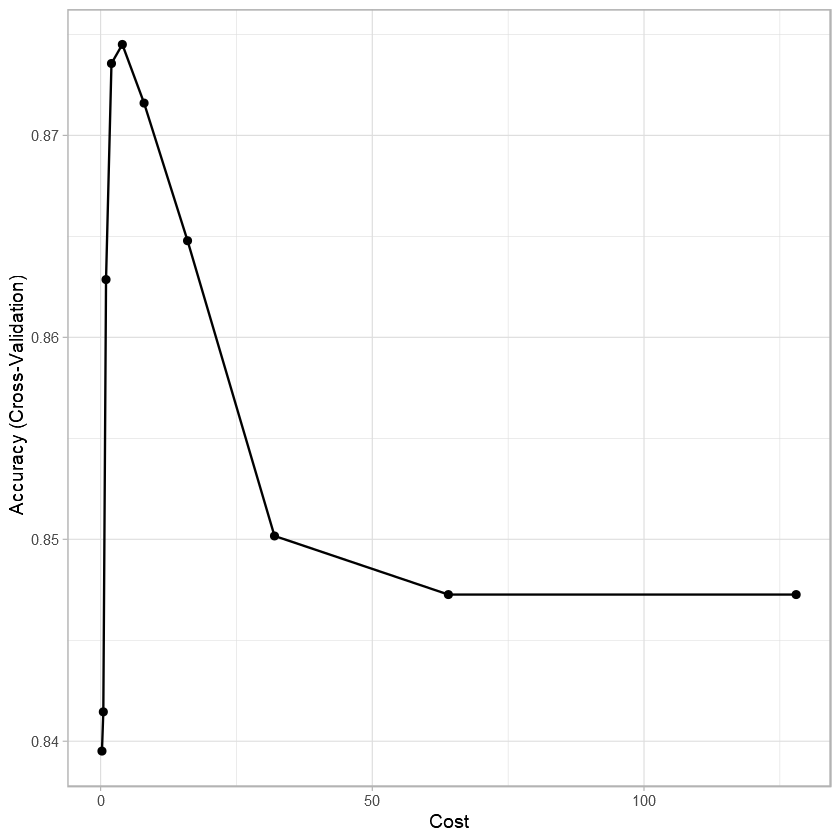

In [23]:
ggplot(churn_svm) + theme_light()

In [38]:
churn_svm$bestTune

,sigma,C
,<dbl>,<dbl>
5,0.01262583,4


#### C = 4, sigma = 0.01262583일때 가장 높은 정확도

In [70]:
pred <- predict(churn_svm, churn_test)

In [59]:
confusionMatrix(pred, churn_test$Attrition)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  356  49
       Yes  14  23
                                          
               Accuracy : 0.8575          
                 95% CI : (0.8214, 0.8887)
    No Information Rate : 0.8371          
    P-Value [Acc > NIR] : 0.136           
                                          
                  Kappa : 0.3502          
                                          
 Mcnemar's Test P-Value : 1.839e-05       
                                          
            Sensitivity : 0.9622          
            Specificity : 0.3194          
         Pos Pred Value : 0.8790          
         Neg Pred Value : 0.6216          
             Prevalence : 0.8371          
         Detection Rate : 0.8054          
   Detection Prevalence : 0.9163          
      Balanced Accuracy : 0.6408          
                                          
       'Positive' Class : No              
                              

### 등급 가중치
- 심각한 클래스 불균형이 있는 상황
- 특정 오분류 비용을 

In [35]:
table(churn_train$Attrition) %>% prop.table


       No       Yes 
0.8394942 0.1605058 

In [61]:
set.seed(1854) 
churn_svm <- train(
  Attrition ~ ., 
  data = churn_train,
  method = "svmRadial",               
  preProcess = c("center", "scale"),  
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 10,
  class.weights = c("No" = 1, "Yes" = 10)
)

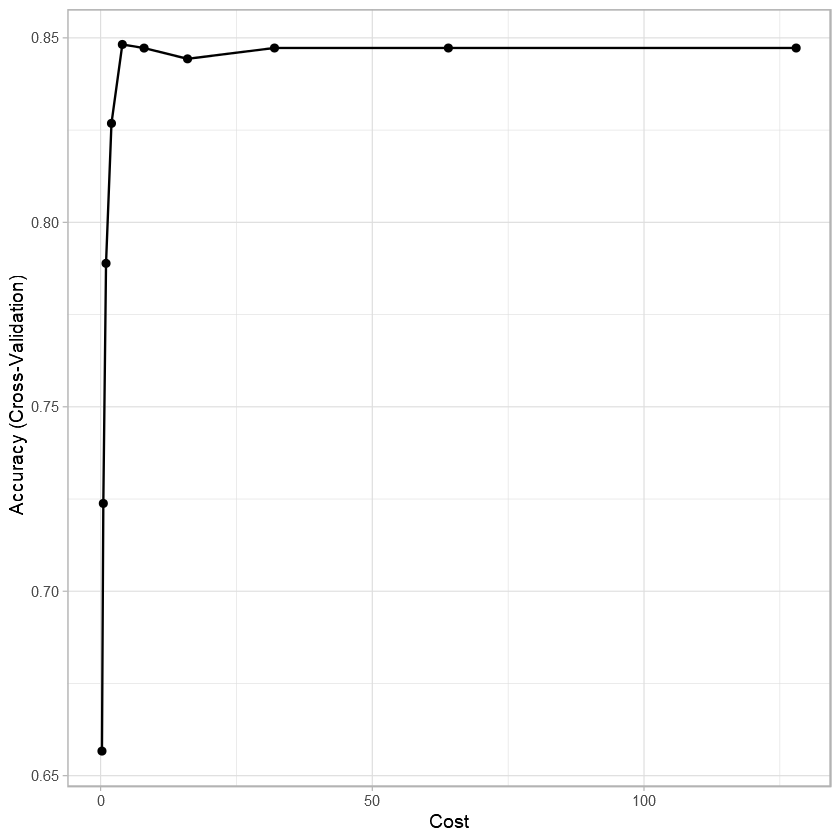

In [62]:
ggplot(churn_svm) + theme_light()

In [63]:
churn_svm$bestTune

,sigma,C
,<dbl>,<dbl>
5,0.01262583,4


In [71]:
pred <- predict(churn_svm, churn_test)

In [72]:
confusionMatrix(pred, churn_test$Attrition)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  337  46
       Yes  33  26
                                          
               Accuracy : 0.8213          
                 95% CI : (0.7823, 0.8559)
    No Information Rate : 0.8371          
    P-Value [Acc > NIR] : 0.8333          
                                          
                  Kappa : 0.2932          
                                          
 Mcnemar's Test P-Value : 0.1770          
                                          
            Sensitivity : 0.9108          
            Specificity : 0.3611          
         Pos Pred Value : 0.8799          
         Neg Pred Value : 0.4407          
             Prevalence : 0.8371          
         Detection Rate : 0.7624          
   Detection Prevalence : 0.8665          
      Balanced Accuracy : 0.6360          
                                          
       'Positive' Class : No              
                              

### 클래스 확률
- 예측된 클래스 확률을 제공
#### ```classProbs = T```

#### AUC값 제공
- 
#### ```summaryFunction = twoClassSummary```

In [73]:
ctrl <- trainControl(
  method = "cv", 
  number = 10, 
  classProbs = TRUE,                 
  summaryFunction = twoClassSummary  
)

#### ```metric = "ROC```

In [74]:
set.seed(5628)  
churn_svm_auc <- train(
  Attrition ~ ., 
  data = churn_train,
  method = "svmRadial",               
  preProcess = c("center", "scale"),  
  metric = "ROC",  # area under ROC curve (AUC)       
  trControl = ctrl,
  tuneLength = 10
)

In [75]:
churn_svm_auc$results %>% head

,sigma,C,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0124187,0.25,0.8361406,0.9640470,0.4238971,0.06416954,0.01934812,0.09188807
2,0.0124187,0.50,0.8361448,0.9628843,0.4062500,0.06435236,0.01962416,0.08215813
3,0.0124187,1.00,0.8373488,0.9733226,0.3878676,0.06482474,0.01816977,0.07562873
4,0.0124187,2.00,0.8364065,0.9744587,0.3996324,0.06507527,0.02037644,0.05400645
5,0.0124187,4.00,0.8284923,0.9802593,0.3327206,0.06638424,0.01902255,0.06706130
6,0.0124187,8.00,0.8204771,0.9767843,0.3264706,0.06323881,0.01734405,0.08816378


In [76]:
churn_svm_auc$bestTune

,sigma,C
,<dbl>,<dbl>
3,0.0124187,1


### 변수 중요도

In [86]:
pred <- predict(churn_svm_auc, churn_test, type = "prob")
head(pred)
pred_yes <- pred$Yes

,No,Yes
,<dbl>,<dbl>
1,0.4931757,0.50682428
2,0.9719103,0.02808971
3,0.7540866,0.24591340
4,0.8520125,0.14798752
5,0.8269005,0.17309948
6,0.9117876,0.08821241


In [95]:
prob_yes <- function(object, newdata) {
  predict(object, newdata = newdata, type = "prob")[, "Yes"]
}

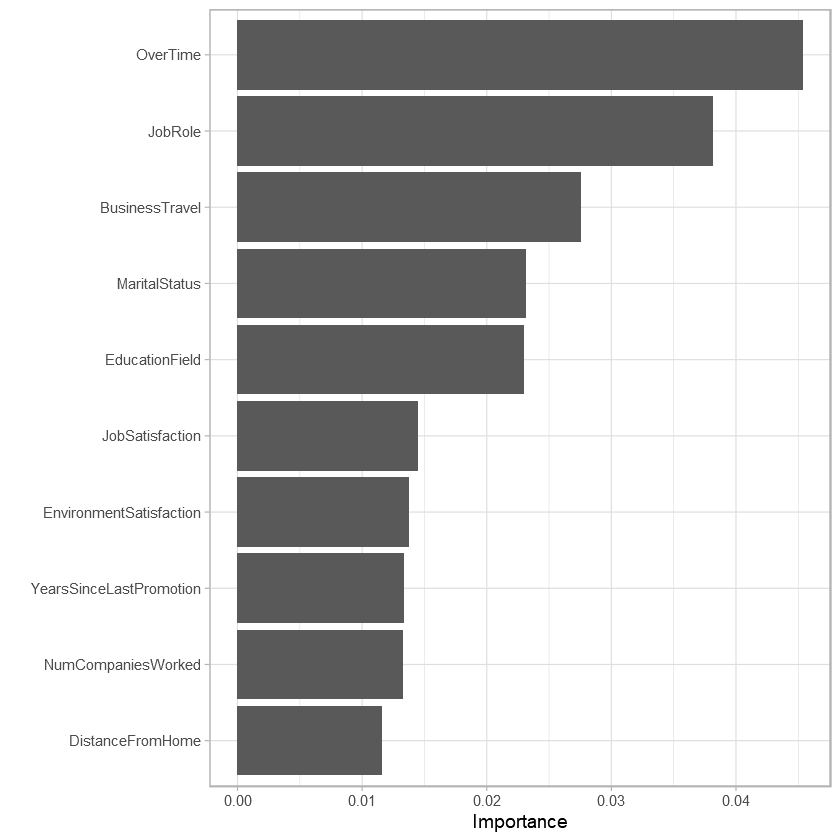

In [96]:
set.seed(2827)  # for reproducibility
vip(churn_svm_auc, method = "permute", nsim = 5, train = churn_train, 
    target = "Attrition", metric = "auc", reference_class = "Yes", 
    pred_wrapper = prob_yes)

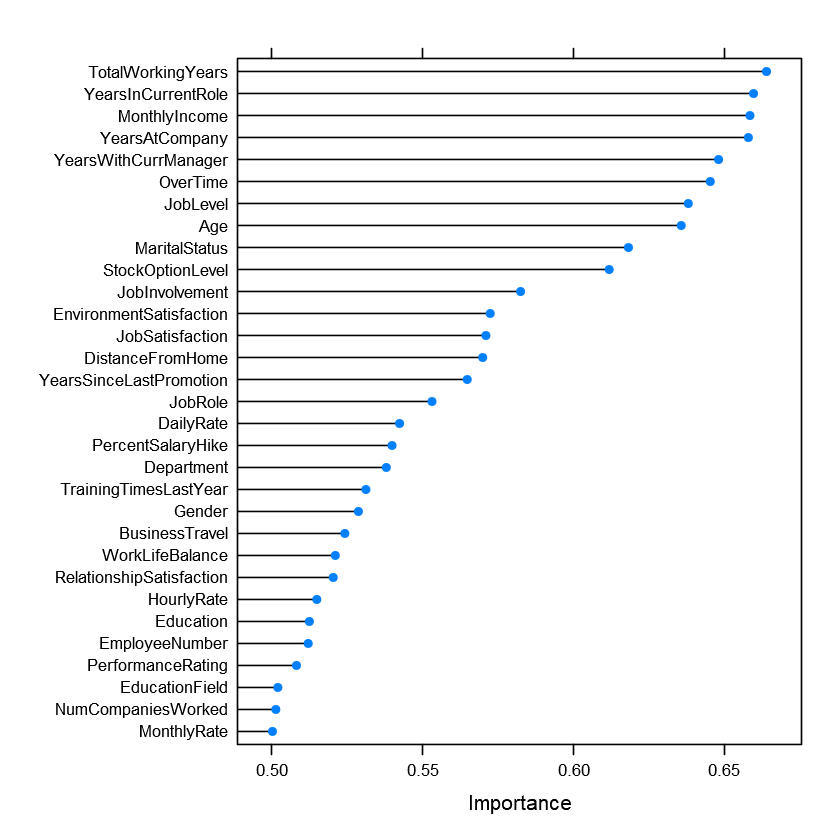

In [93]:
plot(caret::varImp(churn_svm_auc, scale = F))

In [94]:
varImp(churn_svm_auc)

ROC curve variable importance

  only 20 most important variables shown (out of 31)

                        Importance
TotalWorkingYears           100.00
YearsInCurrentRole           97.37
MonthlyIncome                96.65
YearsAtCompany               96.33
YearsWithCurrManager         90.30
OverTime                     88.62
JobLevel                     84.16
Age                          82.74
MaritalStatus                72.06
StockOptionLevel             68.16
JobInvolvement               50.22
EnvironmentSatisfaction      44.07
JobSatisfaction              43.21
DistanceFromHome             42.55
YearsSinceLastPromotion      39.42
JobRole                      32.29
DailyRate                    25.72
PercentSalaryHike            24.21
Department                   23.04
TrainingTimesLastYear        18.91

### PDP

Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."
Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."
Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."
Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."


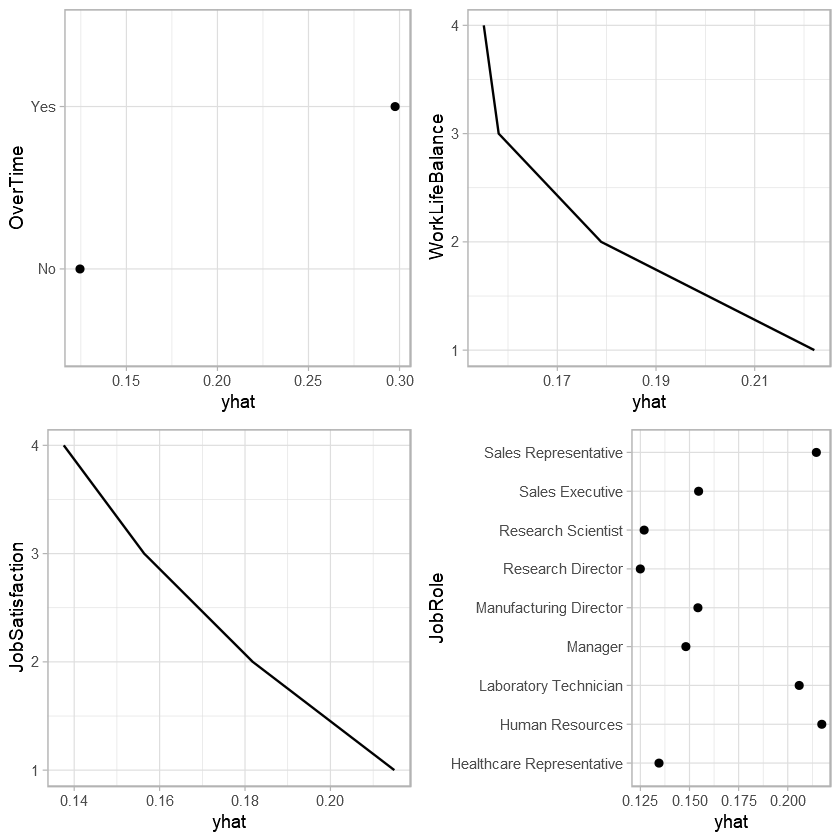

In [97]:
features <- c("OverTime", "WorkLifeBalance", 
              "JobSatisfaction", "JobRole")
pdps <- lapply(features, function(x) {
  partial(churn_svm_auc, pred.var = x, which.class = 2,  
          prob = TRUE, plot = TRUE, plot.engine = "ggplot2") +
    coord_flip()
})
grid.arrange(grobs = pdps,  ncol = 2)